仅保留 California 州

只保留食品类前两个部门

只取加州两个食品部门下的所有商品≈ 全部商品的约 5–8%

In [1]:
import os, time, gc, warnings
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.metrics import mean_squared_error

warnings.filterwarnings("ignore")

# ============ 环境静音 ============ #
os.environ["PYTHONWARNINGS"] = "ignore"
os.environ["LIGHTGBM_VERBOSE"] = "0"
try:
    class _SilentLogger:
        def info(self, msg): pass
        def warning(self, msg): pass
    lgb.register_logger(_SilentLogger())   # 新版 lightgbm 需要 info/warning 方法
except Exception:
    pass

plt.style.use("seaborn-v0_8-whitegrid")

# ============ 路径与参数 ============ #
INPUT_DIR  = "/kaggle/input/m5-forecasting-accuracy/"
WORK_DIR   = "./working/"
os.makedirs(WORK_DIR, exist_ok=True)

END_TRAIN  = 1913         # 用到 d_1913（M5 的标准切分）
HORIZON    = 28
SEED       = 2025

LGB_PARAMS = {
    "objective": "regression",
    "metric": "rmse",
    "boosting_type": "gbdt",
    "learning_rate": 0.05,
    "num_leaves": 64,
    "max_depth": -1,
    "subsample": 0.8,
    "feature_fraction": 0.8,
    "lambda_l2": 0.1,
    "verbosity": -1,
    "device": "gpu",            # ✅ 使用GPU
    "gpu_platform_id": 0,
    "gpu_device_id": 0,
    "max_bin": 63,              # ✅ 提升GPU直方图效率
    "bin_construct_sample_cnt": 500000,
    "gpu_use_dp": False,
    "num_threads": 4,           # ✅ 限制CPU线程，避免CPU过热
    "random_state": SEED,
}

In [2]:
# ============ Step 1: 读取 & 过滤（Mini-Sample）=========== #
print("[1/7] Loading and filtering raw data ...")
usecols_id = ["id","item_id","dept_id","cat_id","store_id","state_id"]
sales = pd.read_csv(os.path.join(INPUT_DIR, "sales_train_evaluation.csv"))
sales = sales[(sales["state_id"]=="CA") & (sales["dept_id"].isin(["FOODS_1","FOODS_2"]))].reset_index(drop=True)

# 宽表 -> 长表
sales = sales.melt(id_vars=usecols_id, var_name="d", value_name="sales")
sales["d"] = sales["d"].str.replace("d_","",regex=False).astype(np.int16)

print(f"  -> items: {sales['id'].nunique()} | rows: {sales.shape[0]:,}")

# ============ Step 2: calendar / prices 合并 ============ #
print("[2/7] Merge calendar and price ...")
calendar = pd.read_csv(os.path.join(INPUT_DIR, "calendar.csv"))
calendar["d"] = calendar["d"].str.replace("d_","",regex=False).astype(np.int16)
cal_keep = ["d","wm_yr_wk","event_name_1","event_type_1","snap_CA","weekday","wday","month","year"]
calendar = calendar[cal_keep]

prices = pd.read_csv(os.path.join(INPUT_DIR, "sell_prices.csv"))
# 合并
df = sales.merge(calendar, on="d", how="left")
df = df.merge(prices, on=["store_id","item_id","wm_yr_wk"], how="left")

# 释放
del sales, calendar, prices
gc.collect()

[1/7] Loading and filtering raw data ...
  -> items: 2456 | rows: 4,767,096
[2/7] Merge calendar and price ...


43

In [3]:
# ============ Step 3: 构造滞后/滚动/时间特征 ============ #
print("[3/7] Build lag / rolling / time features ...")
# 滞后
for lag in tqdm([7,14,28], desc="lag"):
    df[f"lag_{lag}"] = df.groupby("id", sort=False)["sales"].shift(lag)

# 滚动（以 d-28 锚点，避免信息泄露）
for win in tqdm([7,14,28], desc="rmean"):
    df[f"rmean_{win}"] = df.groupby("id", sort=False)["sales"].transform(
        lambda x: x.shift(28).rolling(win).mean()
    )

# 简单时间特征
df["tm_w"]     = (df["d"] % 7).astype(np.int8)
df["tm_m"]     = (df["month"] % 12).astype(np.int8)
df["tm_dw"]    = (df["wday"]).astype(np.int8)
df["tm_w_end"] = (df["tm_dw"]>=6).astype(np.int8)

# 丢弃极早期行（特征为空）
df = df[df["d"]>100].reset_index(drop=True)

# ============ Step 4: 生成标签 F1..F28（多输出）=========== #
print("[4/7] Generate targets F1..F28 ...")
for i in range(1, HORIZON+1):
    df[f"F{i}"] = df.groupby("id", sort=False)["sales"].shift(-i)

# 只用训练期样本，且标签无缺失
label_cols = [f"F{i}" for i in range(1, HORIZON+1)]
train_mask = (df["d"] <= END_TRAIN) & df[label_cols].notna().all(axis=1)
df_tr = df.loc[train_mask].copy()
df_tr.reset_index(drop=True, inplace=True)


[3/7] Build lag / rolling / time features ...


lag:   0%|          | 0/3 [00:00<?, ?it/s]

rmean:   0%|          | 0/3 [00:00<?, ?it/s]

[4/7] Generate targets F1..F28 ...


  -> Train X=(4452728, 11), Y=(4452728, 28)
[5/7] Training LightGBM (GPU) ...


Training targets (F1~F28):   0%|          | 0/28 [00:00<?, ?it/s]

1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.


  ✅ Training completed in 1127.7s
[6/7] Evaluating (train RMSE) ...
  ✅ Training RMSE: 1.92437
[7/7] Plot feature importance ...


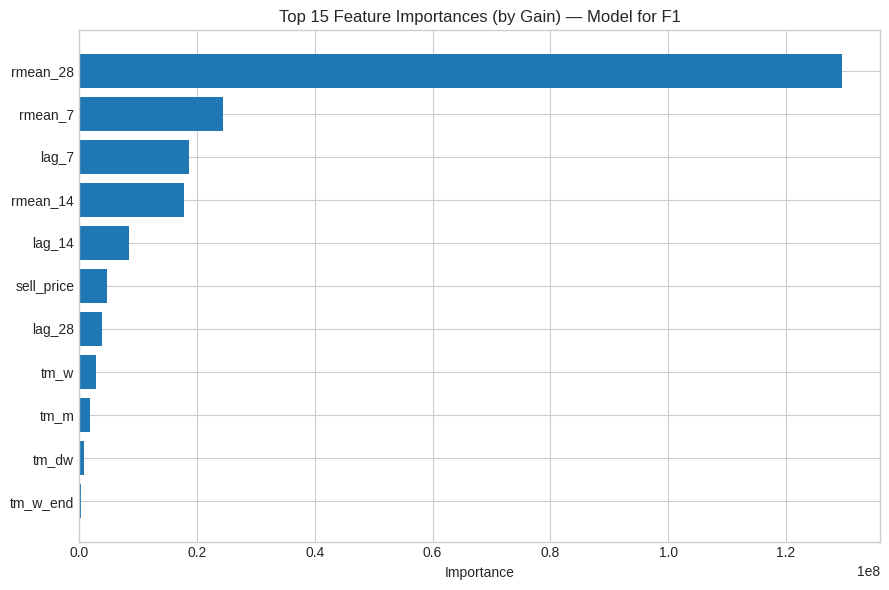


✅ All done. (Mini-Sample GPU) You can proceed to build submission if needed.


In [4]:
# ============ Step 5: 构造 X / Y ============ #
feats = [c for c in df_tr.columns if c.startswith(("lag_","rmean_")) or c in ["sell_price","tm_w","tm_m","tm_dw","tm_w_end"]]
X = df_tr[feats]
Y = df_tr[label_cols]                # DataFrame (n_samples, 28)
print(f"  -> Train X={X.shape}, Y={Y.shape}")

del df, df_tr
gc.collect()

# ============ Step 6: 逐目标训练（带进度条）=========== #
print("[5/7] Training LightGBM (GPU) ...")
start = time.time()

models = []
for tgt in tqdm(label_cols, desc="Training targets (F1~F28)"):
    y = Y[tgt].values         # ✅ DataFrame -> ndarray，避免 .iloc/.loc 混乱
    model_i = lgb.LGBMRegressor(**LGB_PARAMS, n_estimators=400)
    model_i.fit(X, y)
    models.append(model_i)

train_secs = time.time() - start
print(f"  ✅ Training completed in {train_secs:.1f}s")

# ============ Step 7: 训练集 RMSE ============ #
print("[6/7] Evaluating (train RMSE) ...")
Y_pred = np.column_stack([m.predict(X) for m in models])   # (n_samples, 28)
rmse = np.sqrt(mean_squared_error(Y.values.flatten(), Y_pred.flatten()))
print(f"  ✅ Training RMSE: {rmse:.5f}")

# ============ Step 8: Feature Importance（取第一个目标模型）=========== #
print("[7/7] Plot feature importance ...")
imp = models[0].booster_.feature_importance(importance_type="gain")
imp_df = pd.DataFrame({"feature": feats, "importance": imp}).sort_values("importance", ascending=False)

plt.figure(figsize=(9,6))
plt.barh(imp_df["feature"].head(15)[::-1], imp_df["importance"].head(15)[::-1])
plt.title("Top 15 Feature Importances (by Gain) — Model for F1")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

print("\n✅ All done. (Mini-Sample GPU) You can proceed to build submission if needed.")